In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
from pathlib import Path
from typing import Tuple, List, Dict, Optional, Callable, Any
from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from torchvision.transforms import functional as TF

from sklearn.metrics import (
    classification_report, confusion_matrix, precision_score,
    recall_score, f1_score, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)

from PIL import Image, ImageFile
import cv2
import warnings

warnings.filterwarnings('ignore')
ImageFile.LOAD_TRUNCATED_IMAGES = True


@dataclass
class Config:
    """Training configuration"""
    train_dir: str = '/kaggle/input/train'
    test_dir: str = '/kaggle/input/test'
    output_dir: str = '/kaggle/working'
    
    batch_size: int = 16
    img_size: int = 224
    num_epochs: int = 10
    learning_rate: float = 0.0001
    weight_decay: float = 0.05
    num_workers: int = 4
    
    train_split: float = 0.8
    patience: int = 5
    min_delta: float = 0.001
    
    device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Class mapping
    class_to_idx: Dict[str, int] = None
    classes: List[str] = None
    
    def __post_init__(self):
        self.class_to_idx = {'Real': 0, 'Fake': 1}
        self.classes = ['Real', 'Fake']
        Path(self.output_dir).mkdir(parents=True, exist_ok=True)


config = Config()

print(f"Device: {config.device}")
if torch.cuda.is_available():
    print(f"GPU Count: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")

Device: cuda
GPU Count: 2
  GPU 0: Tesla T4
  GPU 1: Tesla T4


In [3]:
class ImageDataset(Dataset):
    """Custom dataset with Real/Fake mapping (Real=0, Fake=1)"""
    
    def __init__(
        self,
        root_dir: str,
        transform: Optional[Callable] = None,
        loader: Optional[Callable] = None
    ) -> None:
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.loader = loader or self._default_loader
        
        self.class_to_idx = {'Real': 0, 'Fake': 1}
        self.classes = ['Real', 'Fake']
        self.samples: List[Tuple[str, int]] = []
        
        self._scan_directory()
    
    def _scan_directory(self) -> None:
        """Scan directory and build samples list"""
        for class_name in os.listdir(self.root_dir):
            class_path = self.root_dir / class_name
            
            if not class_path.is_dir():
                continue
            
            if class_name.lower() == 'real':
                class_idx = 0
            elif class_name.lower() == 'fake':
                class_idx = 1
            else:
                print(f"Warning: Unknown class '{class_name}', skipping...")
                continue
            
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    img_path = str(class_path / img_name)
                    self.samples.append((img_path, class_idx))
        
        print(f"Found {len(self.samples)} images")
        print(f"Classes: {self.classes}")
        print(f"Mapping: {self.class_to_idx}")
    
    @staticmethod
    def _default_loader(path: str) -> Image.Image:
        """Robust image loader with error handling"""
        try:
            with open(path, 'rb') as f:
                img = Image.open(f)
                return img.convert('RGB')
        except Exception as e:
            print(f"Error loading {path}: {e}")
            return Image.new('RGB', (224, 224), color='black')
    
    def __len__(self) -> int:
        return len(self.samples)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        """Returns: (image_tensor, label) where label: 0=Real, 1=Fake"""
        img_path, label = self.samples[idx]
        image = self.loader(img_path)
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label


def get_transforms(config: Config) -> Tuple[transforms.Compose, transforms.Compose]:
    """Create train and validation transforms"""
    train_transform = transforms.Compose([
        transforms.Resize((config.img_size, config.img_size)),
        
        # Геометричні трансформації
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.2),  # Додано
        transforms.RandomRotation(20),  # Збільшено
        transforms.RandomAffine(
            degrees=0, 
            translate=(0.15, 0.15),  # Збільшено
            scale=(0.85, 1.15),      # Додано масштабування
            shear=10                 # Додано зсув
        ),
        
        # Колористичні трансформації
        transforms.ColorJitter(
            brightness=0.3,   # Збільшено
            contrast=0.3,     # Збільшено
            saturation=0.3,   # Збільшено
            hue=0.1          # Додано
        ),
        
        # Додаткові аугментації
        transforms.RandomGrayscale(p=0.1),  # Випадкове чорно-біле
        transforms.RandomPosterize(bits=4, p=0.1),  # Posterization
        transforms.RandomAutocontrast(p=0.1),       # Автоконтраст
        
        # Нормалізація
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        
        # Noise injection (потребує custom transform)
        transforms.RandomApply([transforms.Lambda(lambda x: x + 0.01 * torch.randn_like(x))], p=0.1)
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((config.img_size, config.img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform


print("Dataset and transforms defined successfully")

Dataset and transforms defined successfully



Training Set
--------------------------------------------------
Class 'fake': 24000 images
Class 'real': 24000 images


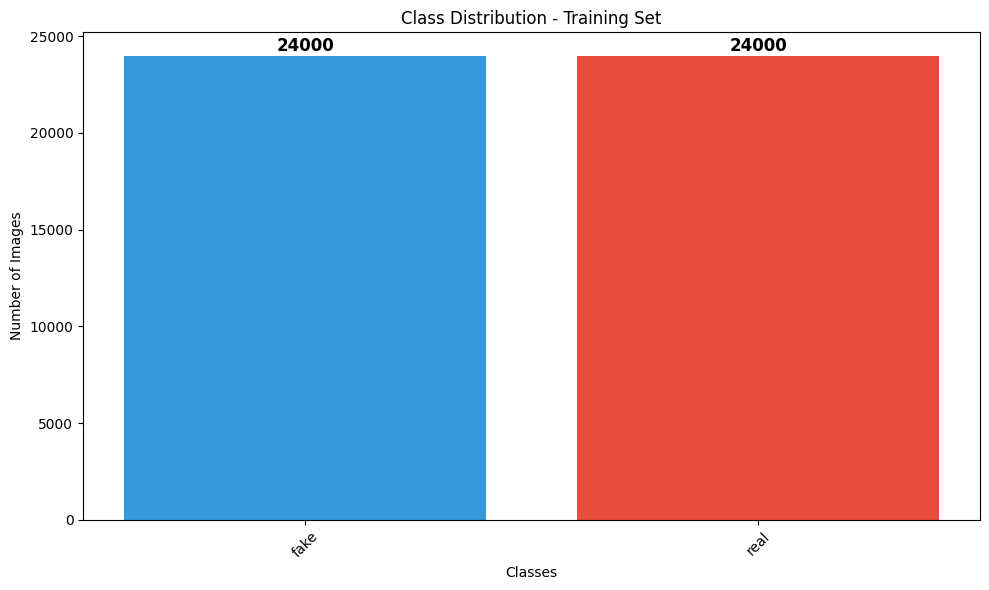


Test Set
--------------------------------------------------
Class 'fake': 6000 images
Class 'real': 6000 images


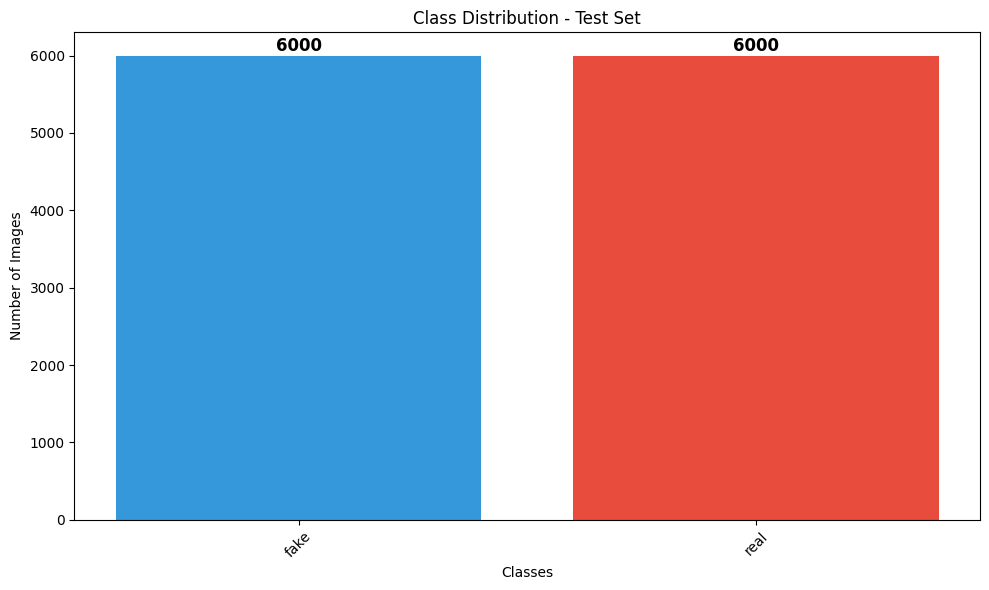

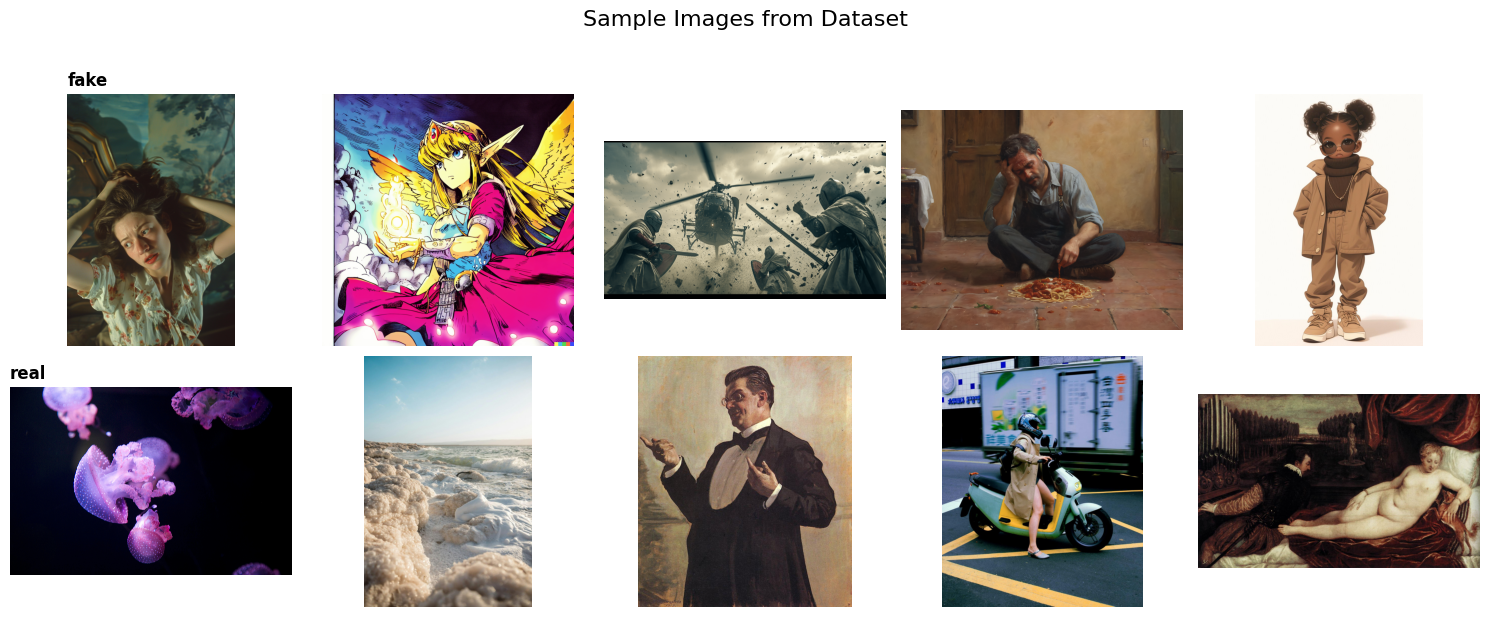

In [4]:
class DatasetAnalyzer:
    """Utility class for dataset analysis and visualization"""
    
    @staticmethod
    def analyze_distribution(
        data_dir: str,
        title: str = "Dataset Distribution"
    ) -> Tuple[List[str], Dict[str, int]]:
        """Analyze and visualize class distribution"""
        print(f"\n{title}")
        print("-" * 50)
        
        classes = sorted(os.listdir(data_dir))
        class_counts = {}
        
        for cls in classes:
            class_path = Path(data_dir) / cls
            if class_path.is_dir():
                count = len([
                    f for f in os.listdir(class_path)
                    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
                ])
                class_counts[cls] = count
                print(f"Class '{cls}': {count} images")
        
        plt.figure(figsize=(10, 6))
        plt.bar(class_counts.keys(), class_counts.values(), color=['#3498db', '#e74c3c'])
        plt.title(f'Class Distribution - {title}')
        plt.xlabel('Classes')
        plt.ylabel('Number of Images')
        plt.xticks(rotation=45)
        
        for i, (cls, count) in enumerate(class_counts.items()):
            plt.text(i, count + 10, str(count), ha='center', va='bottom',
                    fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        return classes, class_counts
    
    @staticmethod
    def visualize_samples(
        data_dir: str,
        classes: List[str],
        samples_per_class: int = 5
    ) -> None:
        """Display sample images from each class"""
        fig, axes = plt.subplots(
            len(classes), samples_per_class,
            figsize=(15, 3 * len(classes))
        )
        fig.suptitle('Sample Images from Dataset', fontsize=16, y=1.02)
        
        for i, cls in enumerate(classes):
            class_path = Path(data_dir) / cls
            images = [
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ][:samples_per_class]
            
            for j, img_name in enumerate(images):
                img_path = class_path / img_name
                img = Image.open(img_path).convert('RGB')
                
                ax = axes[i, j] if len(classes) > 1 else axes[j]
                ax.imshow(img)
                ax.axis('off')
                
                if j == 0:
                    ax.set_title(f'{cls}', fontsize=12, fontweight='bold', loc='left')
        
        plt.tight_layout()
        plt.show()


analyzer = DatasetAnalyzer()

train_classes, train_counts = analyzer.analyze_distribution(
    config.train_dir, "Training Set"
)
test_classes, test_counts = analyzer.analyze_distribution(
    config.test_dir, "Test Set"
)

analyzer.visualize_samples(config.train_dir, train_classes, samples_per_class=5)

In [5]:
train_transform, val_transform = get_transforms(config)

full_train_dataset = ImageDataset(
    config.train_dir,
    transform=train_transform
)

test_dataset = ImageDataset(
    config.test_dir,
    transform=val_transform
)

train_size = int(config.train_split * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

val_dataset.dataset.transform = val_transform

print(f"\nDataset Splits:")
print(f"  Training:   {len(train_dataset):,}")
print(f"  Validation: {len(val_dataset):,}")
print(f"  Test:       {len(test_dataset):,}")
print(f"\nClasses: {test_dataset.classes}")
print(f"Mapping: {test_dataset.class_to_idx}")

train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=True,
    persistent_workers=True
)

print("\nData loaders created successfully")

Found 48000 images
Classes: ['Real', 'Fake']
Mapping: {'Real': 0, 'Fake': 1}
Found 12000 images
Classes: ['Real', 'Fake']
Mapping: {'Real': 0, 'Fake': 1}

Dataset Splits:
  Training:   38,400
  Validation: 9,600
  Test:       12,000

Classes: ['Real', 'Fake']
Mapping: {'Real': 0, 'Fake': 1}

Data loaders created successfully


In [6]:
class EfficientNetClassifier(nn.Module):
    """EfficientNet-B0 binary classifier with Grad-CAM support"""
    
    def __init__(self, num_classes: int = 1, pretrained: bool = True) -> None:
        super().__init__()
        
        self.efficientnet = models.efficientnet_b0(
            weights='DEFAULT' if pretrained else None
        )
        
        self.features = self.efficientnet.features
        self.avgpool = self.efficientnet.avgpool
        
        in_features = self.efficientnet.classifier[1].in_features  # 1280
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=0.3, inplace=True),
            nn.Linear(in_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.4),
            nn.Linear(256, num_classes)
        )
        
        self.gradients: Optional[torch.Tensor] = None
        self.activations: Optional[torch.Tensor] = None
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Standard forward pass"""
        return self.efficientnet(x)
    
    def forward_with_cam(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass with activation storage for Grad-CAM"""
        x = self.features(x)
        self.activations = x
        
        if x.requires_grad:
            x.register_hook(self._save_gradient)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.efficientnet.classifier(x)
        
        return x
    
    def _save_gradient(self, grad: torch.Tensor) -> None:
        """Hook to save gradients for Grad-CAM"""
        self.gradients = grad


def create_model(config: Config) -> nn.Module:
    """Create and initialize model"""
    model = EfficientNetClassifier(num_classes=1, pretrained=True)
    
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs with DataParallel")
        model = nn.DataParallel(model)
    
    model = model.to(config.device)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\nModel: EfficientNet-B0")
    print(f"Total parameters:     {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    return model


model = create_model(config)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 121MB/s] 


Using 2 GPUs with DataParallel

Model: EfficientNet-B0
Total parameters:     4,336,253
Trainable parameters: 4,336,253


In [7]:
class EarlyStopping:
    """Early stopping to prevent overfitting"""
    
    def __init__(
        self,
        patience: int = 5,
        min_delta: float = 0.0,
        verbose: bool = True,
        path: str = 'best_model.pth'
    ) -> None:
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.path = path
        
        self.counter = 0
        self.best_loss: Optional[float] = None
        self.early_stop = False
        self.best_epoch = 0
    
    def __call__(self, val_loss: float, model: nn.Module, epoch: int) -> None:
        if self.best_loss is None:
            self.best_loss = val_loss
            self._save_checkpoint(model)
            self.best_epoch = epoch
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f'Early stopping! Best loss: {self.best_loss:.4f} at epoch {self.best_epoch + 1}')
        else:
            self.best_loss = val_loss
            self._save_checkpoint(model)
            self.counter = 0
            self.best_epoch = epoch
    
    def _save_checkpoint(self, model: nn.Module) -> None:
        if self.verbose:
            print(f'Validation loss improved ({self.best_loss:.4f}). Saving model...')
        torch.save(model.state_dict(), self.path)


class Trainer:
    """Handles model training and validation"""
    
    def __init__(
        self,
        model: nn.Module,
        config: Config,
        train_loader: DataLoader,
        val_loader: DataLoader
    ) -> None:
        self.model = model
        self.config = config
        self.train_loader = train_loader
        self.val_loader = val_loader
        
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = optim.AdamW(
            model.parameters(),
            lr=config.learning_rate,
            weight_decay=config.weight_decay
        )
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer,
            T_max=config.num_epochs,
            eta_min=1e-6
        )
        
        self.history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []
        }
    
    def _train_epoch(self) -> Tuple[float, float]:
        """Train for one epoch"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(self.train_loader, desc='Training', leave=False)
        for inputs, labels in pbar:
            inputs = inputs.to(self.config.device)
            labels = labels.to(self.config.device).float().unsqueeze(1)
            
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({'loss': loss.item(), 'acc': 100. * correct / total})
        
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        return epoch_loss, epoch_acc
    
    def _validate_epoch(self) -> Tuple[float, float]:
        """Validate for one epoch"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            pbar = tqdm(self.val_loader, desc='Validation', leave=False)
            for inputs, labels in pbar:
                inputs = inputs.to(self.config.device)
                labels = labels.to(self.config.device).float().unsqueeze(1)
                
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                pbar.set_postfix({'loss': loss.item(), 'acc': 100. * correct / total})
        
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        return epoch_loss, epoch_acc
    
    def fit(self, early_stopping: EarlyStopping) -> Dict[str, List[float]]:
        """Train model with early stopping"""
        print(f"\n{'=' * 50}")
        print("Training Started")
        print(f"{'=' * 50}")
        
        for epoch in range(self.config.num_epochs):
            print(f'\nEpoch {epoch + 1}/{self.config.num_epochs}')
            print('-' * 50)
            
            train_loss, train_acc = self._train_epoch()
            val_loss, val_acc = self._validate_epoch()
            
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            
            print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc * 100:.2f}%')
            print(f'Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc * 100:.2f}%')
            
            self.scheduler.step()
            early_stopping(val_loss, self.model, epoch)
            
            if early_stopping.early_stop:
                print(f"\n{'=' * 50}")
                print(f"Early stopping at epoch {epoch + 1}")
                print(f"Best val loss: {early_stopping.best_loss:.4f} at epoch {early_stopping.best_epoch + 1}")
                print(f"{'=' * 50}")
                break
        
        print(f"\nTraining completed!")
        print(f"Best validation loss: {early_stopping.best_loss:.4f} (epoch {early_stopping.best_epoch + 1})")
        
        return self.history


print("Training components defined successfully")

Training components defined successfully


In [8]:
early_stopping = EarlyStopping(
    patience=config.patience,
    min_delta=config.min_delta,
    verbose=True,
    path=str(Path(config.output_dir) / 'best_efficientnet_model.pth')
)

trainer = Trainer(
    model=model,
    config=config,
    train_loader=train_loader,
    val_loader=val_loader
)

history = trainer.fit(early_stopping)


Training Started

Epoch 1/10
--------------------------------------------------


Train Loss: 0.3301 | Train Acc: 86.00%
Val Loss:   0.1892 | Val Acc:   92.68%
Validation loss improved (0.1892). Saving model...

Epoch 2/10
--------------------------------------------------


Train Loss: 0.2424 | Train Acc: 90.81%
Val Loss:   0.1602 | Val Acc:   93.86%
Validation loss improved (0.1602). Saving model...

Epoch 3/10
--------------------------------------------------


Train Loss: 0.1969 | Train Acc: 92.90%
Val Loss:   0.1762 | Val Acc:   93.26%
EarlyStopping counter: 1/5

Epoch 4/10
--------------------------------------------------


Train Loss: 0.1610 | Train Acc: 94.58%
Val Loss:   0.1700 | Val Acc:   93.68%
EarlyStopping counter: 2/5

Epoch 5/10
--------------------------------------------------


Train Loss: 0.1309 | Train Acc: 95.76%
Val Loss:   0.1374 | Val Acc:   94.79%
Validation loss improved (0.1374). Saving model...

Epoch 6/10
--------------------------------------------------


Train Loss: 0.1049 | Train Acc: 96.76%
Val Loss:   0.1369 | Val Acc:   95.07%
EarlyStopping counter: 1/5

Epoch 7/10
--------------------------------------------------


Train Loss: 0.0902 | Train Acc: 97.34%
Val Loss:   0.1395 | Val Acc:   95.18%
EarlyStopping counter: 2/5

Epoch 8/10
--------------------------------------------------


Train Loss: 0.0746 | Train Acc: 97.82%
Val Loss:   0.1418 | Val Acc:   95.26%
EarlyStopping counter: 3/5

Epoch 9/10
--------------------------------------------------


Train Loss: 0.0668 | Train Acc: 98.22%
Val Loss:   0.1298 | Val Acc:   95.43%
Validation loss improved (0.1298). Saving model...

Epoch 10/10
--------------------------------------------------


Train Loss: 0.0620 | Train Acc: 98.33%
Val Loss:   0.1251 | Val Acc:   95.73%
Validation loss improved (0.1251). Saving model...

Training completed!
Best validation loss: 0.1251 (epoch 10)


In [9]:
class ModelEvaluator:
    """Evaluate model and compute metrics"""
    
    def __init__(self, model: nn.Module, config: Config) -> None:
        self.model = model
        self.config = config
    
    def evaluate(
        self,
        test_loader: DataLoader
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Evaluate model on test set"""
        self.model.eval()
        
        y_true = []
        y_pred = []
        y_scores = []
        
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc='Testing'):
                inputs = inputs.to(self.config.device)
                outputs = self.model(inputs)
                probs = torch.sigmoid(outputs).cpu().numpy()
                preds = (probs > 0.5).astype(int)
                
                y_true.extend(labels.numpy())
                y_pred.extend(preds.flatten())
                y_scores.extend(probs.flatten())
        
        return np.array(y_true), np.array(y_pred), np.array(y_scores)
    
    @staticmethod
    def compute_metrics(
        y_true: np.ndarray,
        y_pred: np.ndarray,
        y_scores: np.ndarray
    ) -> Dict[str, float]:
        """Compute classification metrics"""
        metrics = {
            'accuracy': (y_true == y_pred).mean(),
            'precision': precision_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred),
            'roc_auc': roc_auc_score(y_true, y_scores),
            'pr_auc': average_precision_score(y_true, y_scores)
        }
        return metrics
    
    @staticmethod
    def print_metrics(metrics: Dict[str, float]) -> None:
        """Print metrics in a formatted way"""
        print(f"\n{'=' * 50}")
        print("Classification Metrics")
        print(f"{'=' * 50}")
        print(f"Accuracy:  {metrics['accuracy'] * 100:.2f}%")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall:    {metrics['recall']:.4f}")
        print(f"F1-Score:  {metrics['f1']:.4f}")
        print(f"ROC AUC:   {metrics['roc_auc']:.4f}")
        print(f"PR AUC:    {metrics['pr_auc']:.4f}")


model.load_state_dict(torch.load(
    str(Path(config.output_dir) / 'best_efficientnet_model.pth')
))

evaluator = ModelEvaluator(model, config)
y_true, y_pred, y_scores = evaluator.evaluate(test_loader)

metrics = evaluator.compute_metrics(y_true, y_pred, y_scores)
evaluator.print_metrics(metrics)

print(f"\n{'-' * 50}")
print("Classification Report")
print(f"{'-' * 50}")
print(classification_report(y_true, y_pred, target_names=['Real', 'Fake']))

Testing: 100%|██████████| 750/750 [08:51<00:00,  1.41it/s]


Classification Metrics
Accuracy:  96.01%
Precision: 0.9707
Recall:    0.9488
F1-Score:  0.9596
ROC AUC:   0.9928
PR AUC:    0.9934

--------------------------------------------------
Classification Report
--------------------------------------------------
              precision    recall  f1-score   support

        Real       0.95      0.97      0.96      6000
        Fake       0.97      0.95      0.96      6000

    accuracy                           0.96     12000
   macro avg       0.96      0.96      0.96     12000
weighted avg       0.96      0.96      0.96     12000



In [10]:
class GradCAM:
    """Generate Grad-CAM heatmaps"""
    
    def __init__(self, model: nn.Module) -> None:
        self.model = model
        self.model.eval()
    
    def generate_cam(
        self,
        input_tensor: torch.Tensor,
        target_class: Optional[int] = None
    ) -> np.ndarray:
        """Generate Grad-CAM heatmap [H, W]"""
        score = self.model.forward_with_cam(input_tensor)
        
        if target_class is None:
            target_class = torch.sigmoid(score).round().long().item()
        
        output = score if int(target_class) == 1 else -score
        
        self.model.zero_grad()
        output.backward(retain_graph=True)
        
        gradients = self.model.gradients  # [1, C, H, W]
        activations = self.model.activations  # [1, C, H, W]
        
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)  # [1, C, 1, 1]
        cam = torch.sum(weights * activations, dim=1).squeeze()  # [H, W]
        cam = torch.relu(cam)
        
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        
        return cam.detach().cpu().numpy()


class GradCAMVisualizer:
    """Visualize Grad-CAM heatmaps"""
    
    @staticmethod
    def apply_colormap(
        org_img: Image.Image,
        activation_map: np.ndarray,
        colormap: int = cv2.COLORMAP_JET
    ) -> Tuple[np.ndarray, np.ndarray]:
        """Apply heatmap overlay on original image"""
        if isinstance(org_img, Image.Image):
            org_img = np.array(org_img)
        
        heatmap = cv2.resize(activation_map, (org_img.shape[1], org_img.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, colormap)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        
        overlayed = cv2.addWeighted(org_img, 0.6, heatmap, 0.4, 0)
        
        return heatmap, overlayed
    
    @staticmethod
    def visualize_single(
        model: nn.Module,
        image_tensor: torch.Tensor,
        original_image: Image.Image,
        device: torch.device,
        save_path: Optional[str] = None
    ) -> None:
        """Visualize Grad-CAM for a single image"""
        net = model.module if isinstance(model, nn.DataParallel) else model
        net.eval()
        
        image_tensor = image_tensor.unsqueeze(0).to(device)
        image_tensor.requires_grad = True
        
        grad_cam = GradCAM(net)
        cam = grad_cam.generate_cam(image_tensor)
        
        with torch.no_grad():
            output = net(image_tensor)
            prediction = torch.sigmoid(output).item()
        
        heatmap, overlayed = GradCAMVisualizer.apply_colormap(original_image, cam)
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(original_image)
        axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
        axes[0].axis('off')
        
        axes[1].imshow(heatmap)
        axes[1].set_title('Grad-CAM Heatmap', fontsize=12, fontweight='bold')
        axes[1].axis('off')
        
        pred_class = "Fake" if prediction > 0.5 else "Real"
        axes[2].imshow(overlayed)
        axes[2].set_title(
            f'Grad-CAM Overlay\nPrediction: {pred_class} ({prediction:.3f})',
            fontsize=12, fontweight='bold'
        )
        axes[2].axis('off')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    @staticmethod
    def visualize_multiple(
        model: nn.Module,
        test_dataset: ImageDataset,
        transform: transforms.Compose,
        device: torch.device,
        num_samples: int = 6,
        save_path: Optional[str] = None
    ) -> None:
        """Visualize Grad-CAM for multiple test images"""
        net = model.module if isinstance(model, nn.DataParallel) else model
        net.eval()
        
        indices = np.random.choice(len(test_dataset), num_samples, replace=False)
        
        fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
        fig.suptitle(
            'Grad-CAM Visualization on Test Images',
            fontsize=16, fontweight='bold', y=0.995
        )
        
        grad_cam = GradCAM(net)
        
        for idx, test_idx in enumerate(indices):
            img_path, true_label_idx = test_dataset.samples[test_idx]
            original_img = Image.open(img_path).convert('RGB')
            img_tensor = transform(original_img)
            
            img_tensor_batch = img_tensor.unsqueeze(0).to(device)
            img_tensor_batch.requires_grad = True
            
            cam = grad_cam.generate_cam(img_tensor_batch)
            
            with torch.no_grad():
                output = net(img_tensor_batch)
                prediction = torch.sigmoid(output).item()
            
            heatmap, overlayed = GradCAMVisualizer.apply_colormap(original_img, cam)
            
            axes[idx, 0].imshow(original_img)
            axes[idx, 0].set_title(f'Image {idx + 1}', fontsize=10, fontweight='bold')
            axes[idx, 0].axis('off')
            
            axes[idx, 1].imshow(heatmap)
            axes[idx, 1].set_title('Grad-CAM Heatmap', fontsize=10, fontweight='bold')
            axes[idx, 1].axis('off')
            
            true_label = test_dataset.classes[true_label_idx]
            pred_class = "Fake" if prediction > 0.5 else "Real"
            axes[idx, 2].imshow(overlayed)
            axes[idx, 2].set_title(
                f'Overlay | True: {true_label}\nPrediction: {pred_class} ({prediction:.3f})',
                fontsize=10, fontweight='bold'
            )
            axes[idx, 2].axis('off')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()


print("Grad-CAM components defined successfully")

Grad-CAM components defined successfully


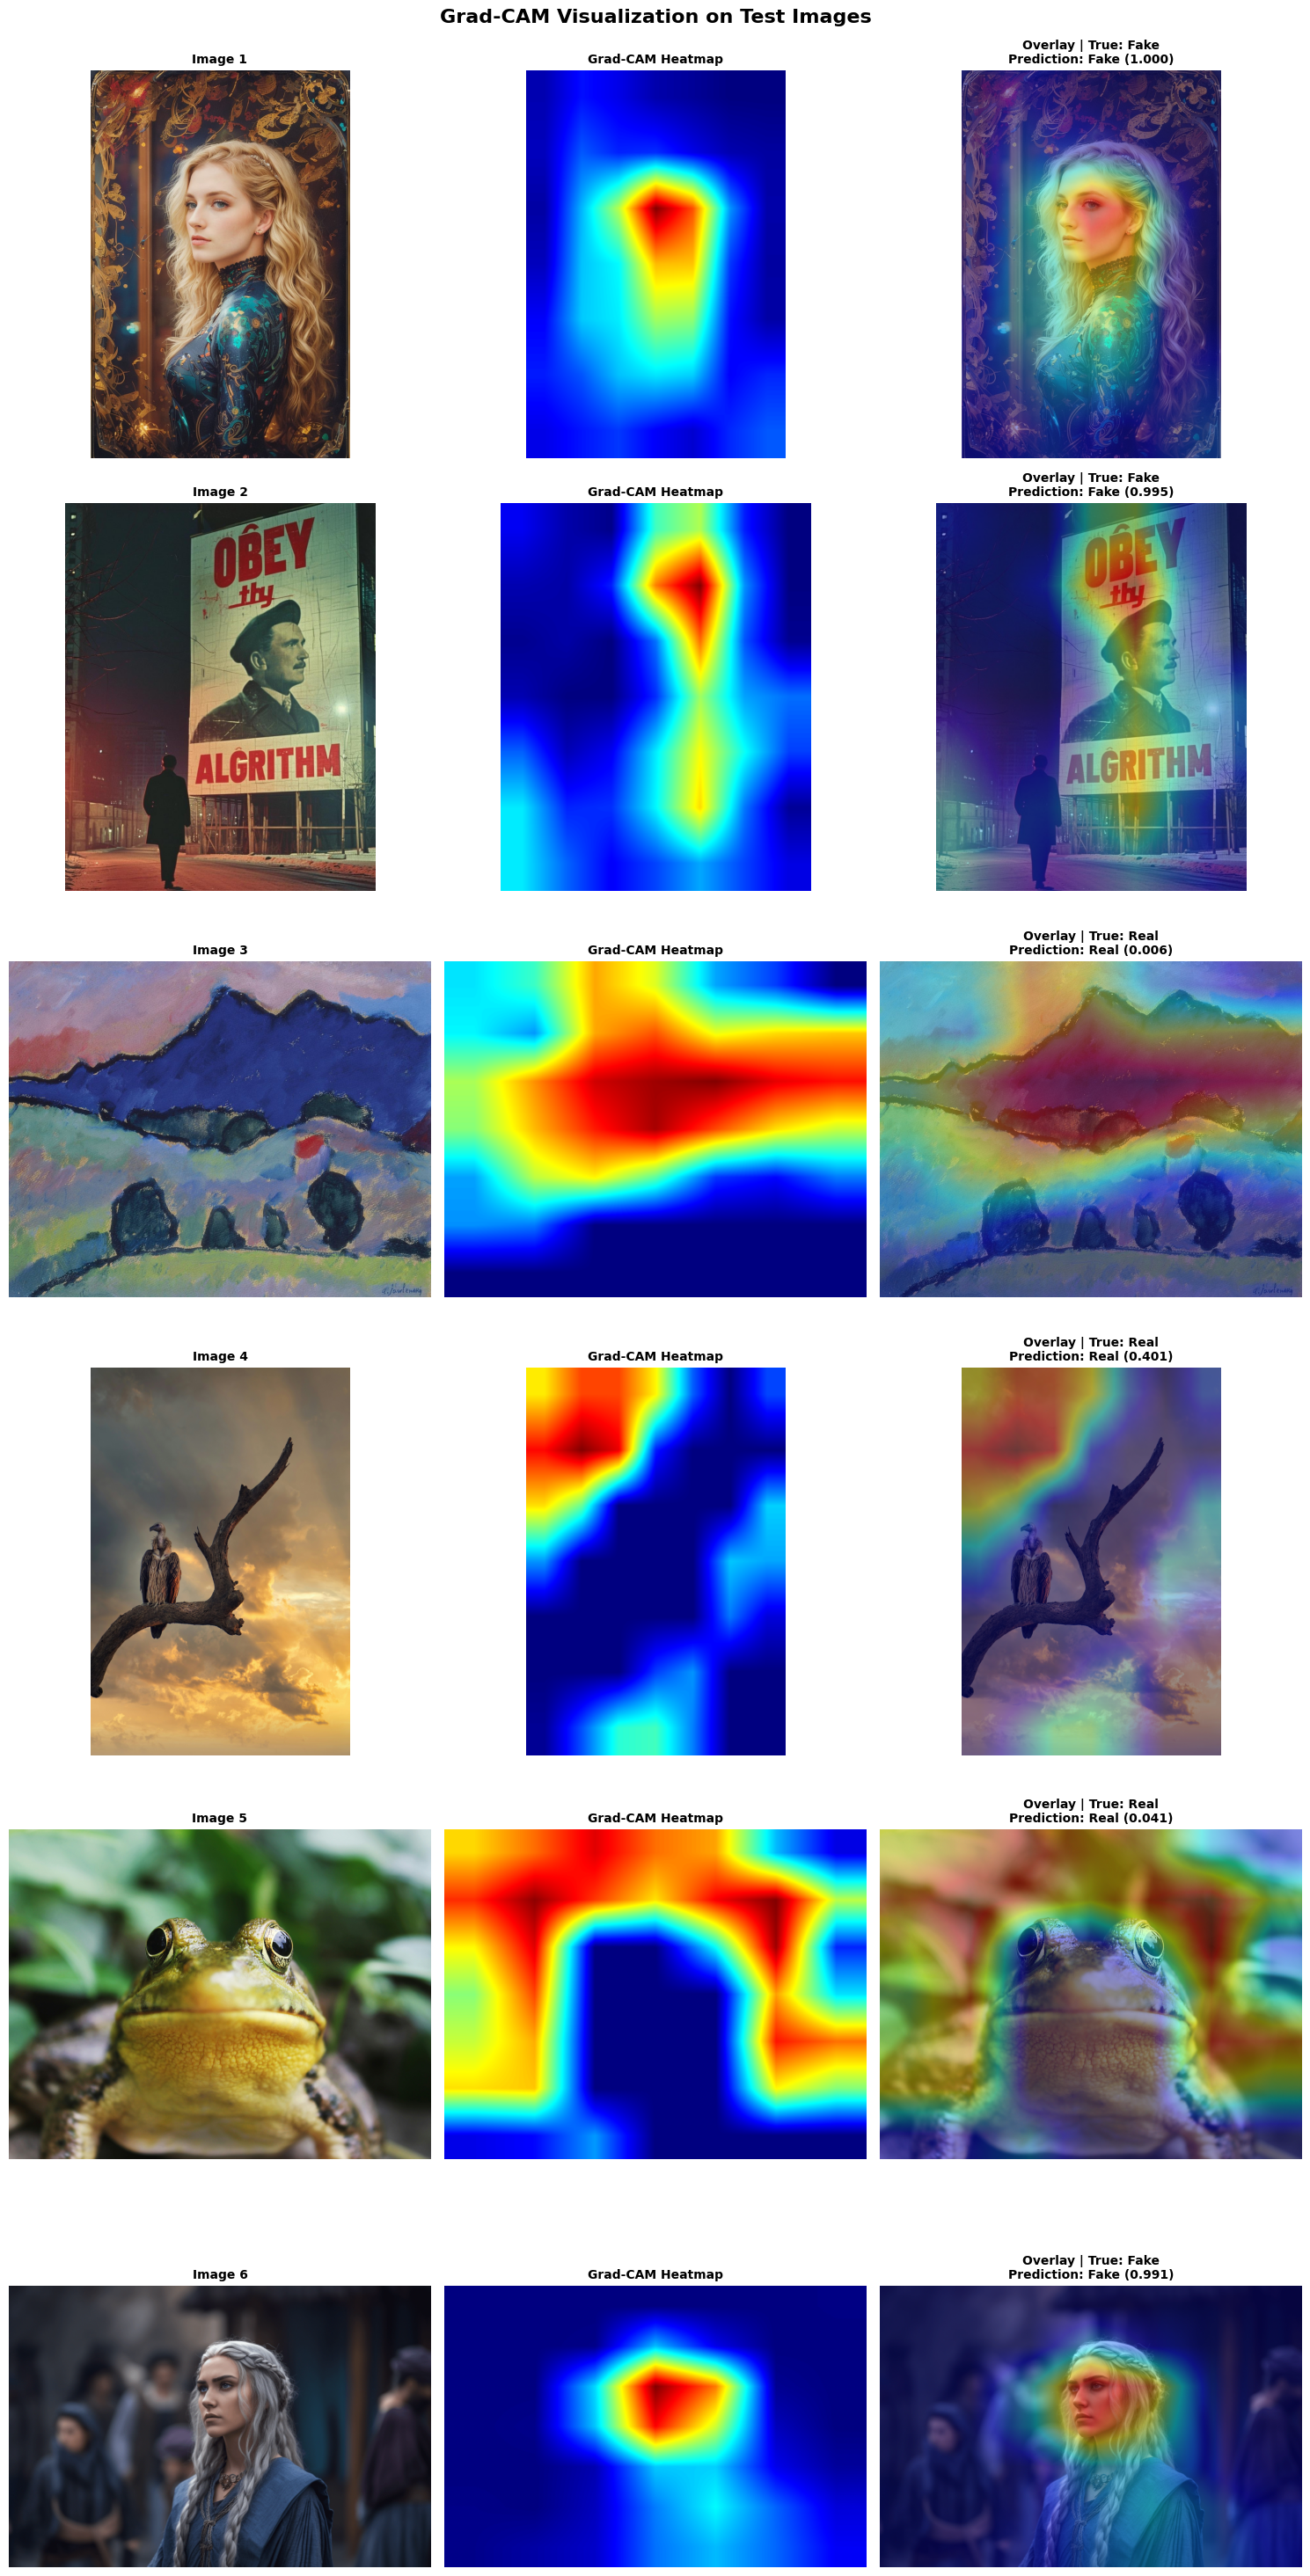

In [11]:
visualizer = GradCAMVisualizer()

visualizer.visualize_multiple(
    model=model,
    test_dataset=test_dataset,
    transform=val_transform,
    device=config.device,
    num_samples=6,
    save_path=str(Path(config.output_dir) / 'gradcam_visualization_multiple.png')
)

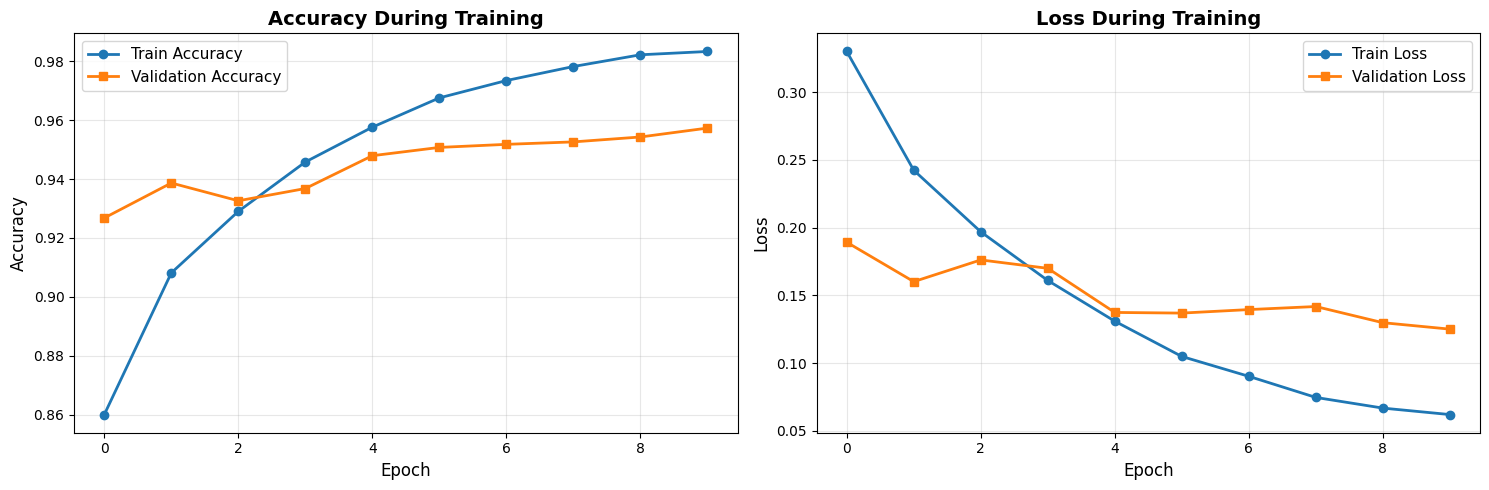

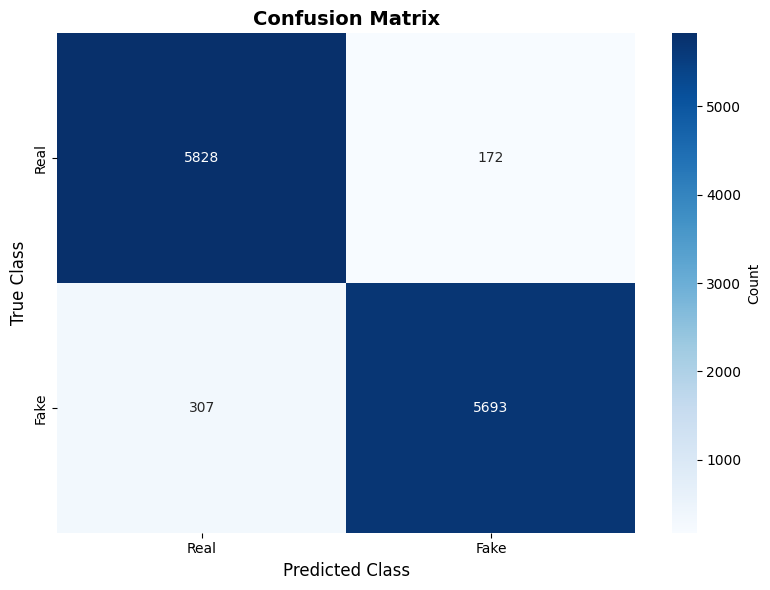

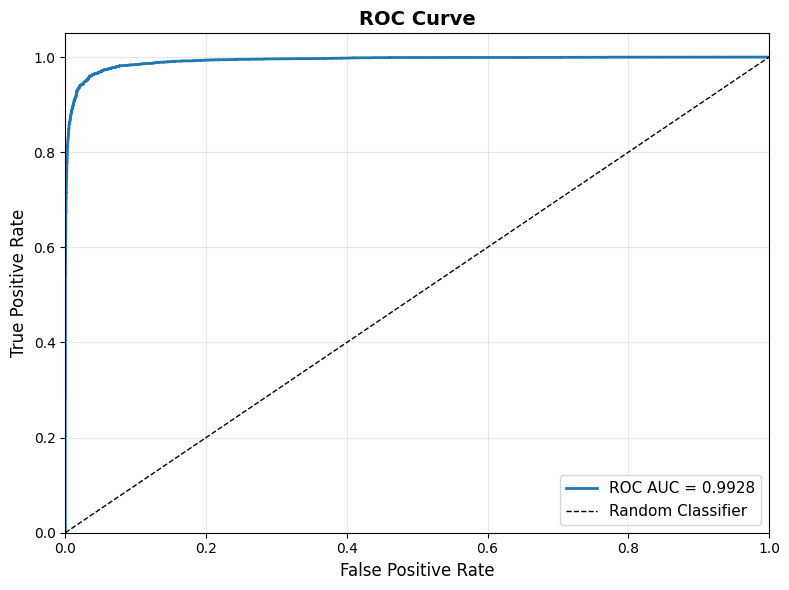

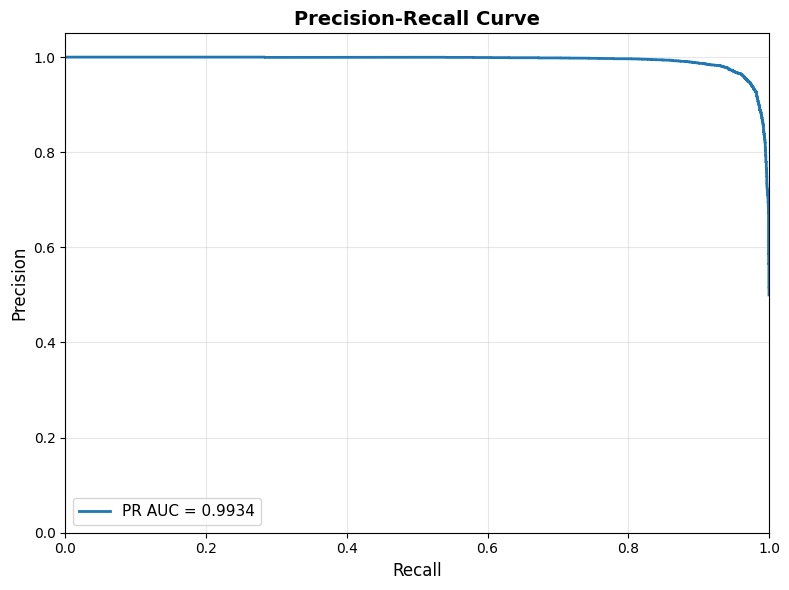


Analysis Complete!

All outputs saved to: /kaggle/working


In [12]:
class ResultVisualizer:
    """Visualize training results and evaluation metrics"""
    
    @staticmethod
    def plot_training_curves(
        history: Dict[str, List[float]],
        save_path: Optional[str] = None
    ) -> None:
        """Plot training and validation curves"""
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        axes[0].plot(history['train_acc'], label='Train Accuracy',
                    linewidth=2, marker='o')
        axes[0].plot(history['val_acc'], label='Validation Accuracy',
                    linewidth=2, marker='s')
        axes[0].set_title('Accuracy During Training', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Epoch', fontsize=12)
        axes[0].set_ylabel('Accuracy', fontsize=12)
        axes[0].legend(fontsize=11)
        axes[0].grid(True, alpha=0.3)
        
        axes[1].plot(history['train_loss'], label='Train Loss',
                    linewidth=2, marker='o')
        axes[1].plot(history['val_loss'], label='Validation Loss',
                    linewidth=2, marker='s')
        axes[1].set_title('Loss During Training', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Epoch', fontsize=12)
        axes[1].set_ylabel('Loss', fontsize=12)
        axes[1].legend(fontsize=11)
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    @staticmethod
    def plot_confusion_matrix(
        y_true: np.ndarray,
        y_pred: np.ndarray,
        class_names: List[str] = ['Real', 'Fake'],
        save_path: Optional[str] = None
    ) -> None:
        """Plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'}
        )
        plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
        plt.xlabel('Predicted Class', fontsize=12)
        plt.ylabel('True Class', fontsize=12)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    @staticmethod
    def plot_roc_curve(
        y_true: np.ndarray,
        y_scores: np.ndarray,
        roc_auc: float,
        save_path: Optional[str] = None
    ) -> None:
        """Plot ROC curve"""
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, linewidth=2, label=f'ROC AUC = {roc_auc:.4f}')
        plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('ROC Curve', fontsize=14, fontweight='bold')
        plt.legend(loc="lower right", fontsize=11)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    @staticmethod
    def plot_precision_recall_curve(
        y_true: np.ndarray,
        y_scores: np.ndarray,
        pr_auc: float,
        save_path: Optional[str] = None
    ) -> None:
        """Plot Precision-Recall curve"""
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, linewidth=2, label=f'PR AUC = {pr_auc:.4f}')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall', fontsize=12)
        plt.ylabel('Precision', fontsize=12)
        plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
        plt.legend(loc="lower left", fontsize=11)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()


viz = ResultVisualizer()

viz.plot_training_curves(
    history,
    save_path=str(Path(config.output_dir) / 'training_curves.png')
)

viz.plot_confusion_matrix(
    y_true, y_pred,
    save_path=str(Path(config.output_dir) / 'confusion_matrix.png')
)

viz.plot_roc_curve(
    y_true, y_scores, metrics['roc_auc'],
    save_path=str(Path(config.output_dir) / 'roc_curve.png')
)

viz.plot_precision_recall_curve(
    y_true, y_scores, metrics['pr_auc'],
    save_path=str(Path(config.output_dir) / 'precision_recall_curve.png')
)

print(f"\n{'=' * 50}")
print("Analysis Complete!")
print(f"{'=' * 50}")
print(f"\nAll outputs saved to: {config.output_dir}")